<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/baseline_lgb_2016_19_title_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/MyDrive/Movies/data/mojo_japan/' '/content/'

!cp -r '/content/drive/MyDrive/Movies/data/metadata_filmarks/' '/content/'

In [3]:
!pip install japanize_matplotlib
import pandas as pd
import codecs 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

import warnings

import os
from tqdm import tqdm
import gc

In [4]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import r2_score
#r2_score(y_true, y_pred)

In [5]:
path = '/content/drive/MyDrive/Movies/preprocessed/'

In [6]:
def read_data(path, encode_type):
  
  with codecs.open(path, "r", encode_type, "ignore") as file:
    output = pd.read_csv(file, delimiter=",")
      
  return output

In [7]:
train = read_data(path+'train_2016-2018_title.csv', encode_type='utf-8')
test = read_data(path+'test_2019_title.csv', encode_type='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5628) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
train['directors'].value_counts()

デヴィッド・イェーツ    9
三池崇史          8
ラッセ・ハルストレム    8
山崎貴           8
三木孝浩          7
             ..
トム・フーパー       1
D・J・カルーソー     1
ピーター・ソーン      1
赤根和樹          1
ティム・バートン      1
Name: directors, Length: 385, dtype: int64

#前処理必要なカラム

> Theaters,Opening_Day,Country


> 今回，前処理されていないカラムname, Distributors

# 標準化が必要なカラム

> 'レビュー数', '平均スコア', 'Gross', 'Total Gross',    'Theaters'

In [9]:
train[train['Theaters']=='-'].__len__()

269

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


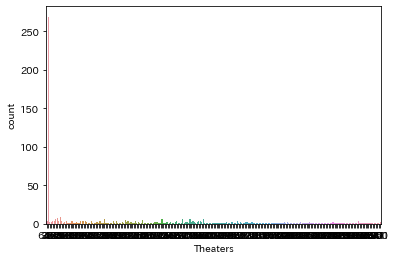

In [10]:
sns.countplot(train['Theaters'])

In [11]:
train['Theaters'].unique()

array(['645', '-', '365', '362', '468', '396', '366', '35', '746', '9',
       '62', '773', '375', '301', '568', '585', '371', '308', '709',
       '353', '322', '457', '775', '329', '360', '634', '332', '313', '1',
       '676', '291', '785', '347', '444', '682', '574', '970', '5', '128',
       '8', '596', '299', '156', '341', '314', '455', '745', '431', '705',
       '300', '275', '636', '342', '312', '4', '296', '331', '285', '696',
       '728', '6', '326', '252', '765', '406', '306', '198', '685', '756',
       '401', '302', '251', '148', '69', '59', '155', '273', '394', '52',
       '65', '196', '40', '150', '56', '246', '464', '180', '86', '120',
       '161', '33', '188', '34', '7', '210', '27', '101', '12', '50',
       '15', '16', '99', '25', '10', '483', '2', '22', '461', '640',
       '789', '673', '323', '417', '463', '260', '337', '193', '432',
       '249', '127', '231', '207', '336', '425', '194', '182', '235',
       '199', '113', '359', '145', '45', '28', '75', '226'

In [12]:
def preprocess_Theaters(input_df:pd.DataFrame)->pd.DataFrame:
  output_df = input_df.copy()
  plt.figure(figsize=(25,10))
  sns.countplot(input_df.loc[input_df['Theaters']!='-', 'Theaters'].astype(int).sort_values())
  plt.xticks(rotation=90)
  plt.show()
  print('- of number : {}'.format(input_df[input_df['Theaters']=='-'].__len__()))
  mean_ = input_df.loc[input_df['Theaters']!='-','Theaters'].astype(int).mean()

  print(f'mean of Theaters:{int(mean_)}')
  output_df['Theaters'] = output_df['Theaters'].replace('-', mean_).astype(int)

  return output_df

def lable_encoding(input_df:pd.DataFrame, cat_cols:list)->pd.DataFrame:
  output_df = input_df.copy()
  # カテゴリ変数は出現順にLabelEncoding
  for c in cat_cols:
    _dict = {j:i for i,j in enumerate(input_df[c].unique())}
    output_df[c] = input_df[c].map(_dict)
    
  return output_df

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


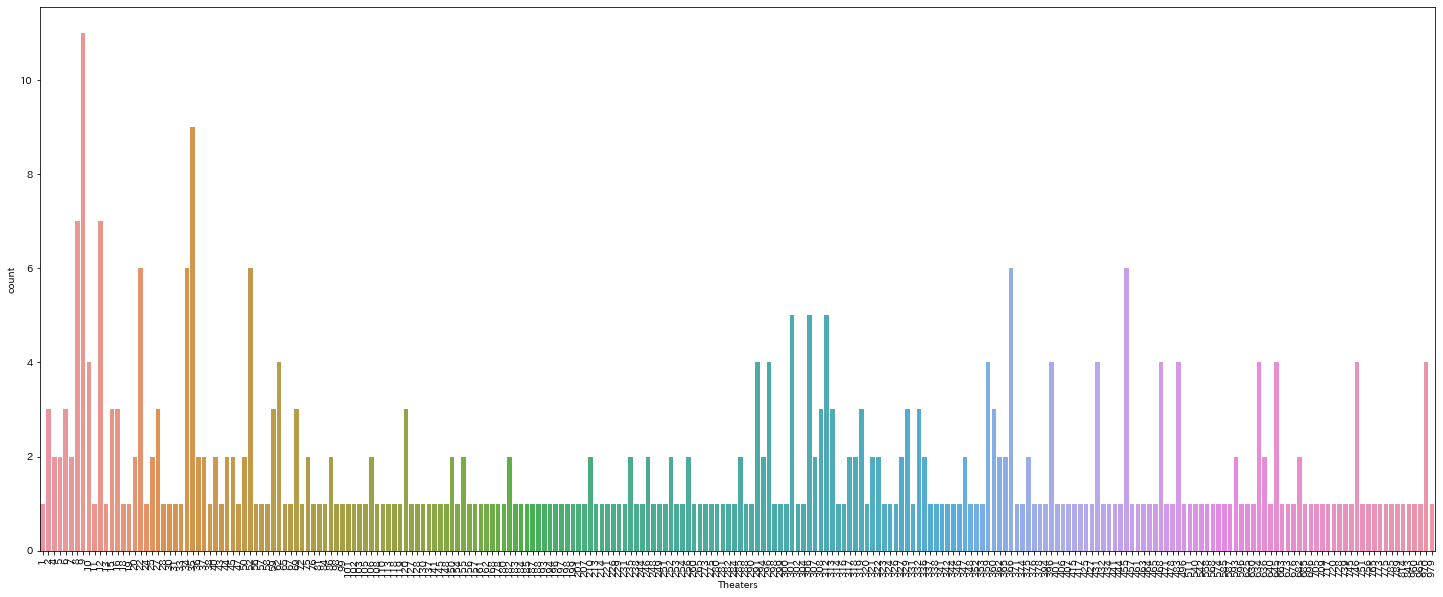

- of number : 395
mean of Theaters:272


In [13]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = preprocess_Theaters(data)

In [14]:
cols=['Country', 'Opening_Day']
data = lable_encoding(data, cols)

In [15]:
train = data[0:len(train)]
test = data[len(train):]

train.shape, test.shape

((642, 9063), (167, 9063))

In [16]:
train['Theaters'].describe()

count    642.000000
mean     279.218069
std      176.262796
min        1.000000
25%      235.750000
50%      272.000000
75%      308.000000
max      979.000000
Name: Theaters, dtype: float64

In [17]:
#アルゴリズムの方で分岐しているから必要ないかもしれない特徴量

def make_describe_col(input_df:pd.DataFrame, col:str):
  output_df = input_df.copy() 
  p_25 = output_df[col].describe()['25%']
  p_50 = output_df[col].describe()['50%']
  p_75 = output_df[col].describe()['75%']

  # 25%未満
  output_df[f'{col}_[x<25%]'] = output_df[col].apply(
      lambda x: 1 if x<p_25 else 0 
  )
  # 25%以上 50%未満
  output_df[f'{col}_[25<=x<50%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_25 and x<p_50 else 0 
  )
  # 50%以上 75%未満
  output_df[f'{col}_[50<=x<75%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_50 and x<p_75 else 0 
  )
  # 75%以上
  output_df[f'{col}_[75%<x]'] = output_df[col].apply(
      lambda x: 1 if x>=p_75 else 0 
  )

  return output_df

In [18]:
train = make_describe_col(train, 'Theaters')
train = make_describe_col(train, 'Time')

test = make_describe_col(test, 'Theaters')
test = make_describe_col(test, 'Time')

In [19]:
from sklearn import preprocessing

def normalization(df:pd.DataFrame, cols:list):
  output_df = df.copy()

  ss = preprocessing.StandardScaler()
  output_df[cols]= ss.fit_transform(output_df[cols])
  output_df[cols].add_suffix('_ss')

  return output_df 

In [20]:
""" use_columns = [
        'レビュー数',
        '平均スコア', 
        'Gross', 
        'Total Gross',
        'Theaters' ]

train = normalization(train, use_columns)
test = normalization(test, use_columns)"""

" use_columns = [\n        'レビュー数',\n        '平均スコア', \n        'Gross', \n        'Total Gross',\n        'Theaters' ]\n\ntrain = normalization(train, use_columns)\ntest = normalization(test, use_columns)"

# Training and Predicting 

##Making Folds

##Kfold

In [21]:
def create_folds(df, NUM_SPLITS, target):
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values   
    tkf = KFold(n_splits=NUM_SPLITS)
    for f, (t_, v_) in enumerate(tkf.split(X=df, y=y)):
        df.loc[v_,'kfold'] = f ###locより高速
    return df

# Custom Metric

In [22]:
from sklearn.metrics import mean_squared_log_error

def RMSLE(preds, data):
  y_true = data.get_label()
  score = np.sqrt(mean_squared_log_error(y_true, preds))
  return "RMSLE", score, True

from sklearn.metrics import mean_squared_error

def RMSE(preds, data):
  y_true = data.get_label() 
  score = np.sqrt(mean_squared_error(y_true, preds))

  return "RMSE", score, True

def metrics(preds, data):
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1score_macro(preds, data),
        #RMSLE(preds, data),
        RMSE(preds, data)
    ]

In [23]:
from sklearn.metrics import r2_score

def trainer(train_df:pd.DataFrame, test_df:pd.DataFrame, target:str, fold:int, params:dict=None):
    df = train_df.copy()
    test = test_df.copy() 

    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    del df 

    train_X = train_df.drop([target, 'kfold'], axis=1)
    #train_y = train_df[target]
    train_y = np.log1p(train_df[target])

    del train_df

    valid_X = valid_df.drop([target, 'kfold'], axis=1)
    #valid_y = valid_df[target]
    valid_y = np.log1p(valid_df[target])

    del valid_df


    dtrain = lgb.Dataset(train_X, train_y)
    dvalid = lgb.Dataset(valid_X, valid_y)

  
    if params is None:
        params = {}
  
    FIT_PARAMS_LGB = {
        "num_boost_round": 10000, 
        "early_stopping_rounds": 100, 
        "verbose_eval":100}

    evals_result = {}
    model = lgb.train(
      params, dtrain, **FIT_PARAMS_LGB,
      valid_names=['train', 'valid'], 
      valid_sets=[dtrain, dvalid],

      evals_result=evals_result,
      #feval=metrics
        )
  
    valid_pred = model.predict(valid_X,
                          num_iteration=model.best_iteration)
  
    test_pred = model.predict(test , axis=1,
                              num_iteration=model.best_iteration)
    
    #test['predict'] = np.stack(pred).mean(axis=0)

    
    RMSE = mean_squared_error(valid_y, valid_pred)**0.5
    print('Fold {} : RMSE {}'.format(fold, RMSE))
    
    R2 = r2_score(valid_y, valid_pred)
    print('Fold {} : R2 {}'.format(fold, R2))

    #model.save_model('/content/drive/MyDrive/SIGNATE_intern/model/lgb_fold{}.txt'.format(fold),
    #                 num_iteration=model.best_iteration)

    #model = lgb.Booster(model_file='*****.txt') で読み込める
    gc.collect()

    return valid_pred, test_pred, RMSE, evals_result, model

In [24]:
def create_folds(df:pd.DataFrame, target:str, NUM_SPLITS:int ):
    RANDOM_SEED=1
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values 
    kf = KFold(n_splits=NUM_SPLITS, random_state=RANDOM_SEED)
    for f, (t_, v_) in enumerate(kf.split(X=df)):
        df.loc[v_,'kfold'] = f 
    return df

#目的変数と説明変数の設定




In [25]:
#レビュー，平均スコアを含める場合
#drop_cols=['Title','Title(ja)','directors','writers','casts']

#----------------------------------------------------------------
#レビュー，平均スコアを含めない場合
drop_cols=['Title','Title(ja)','directors','writers','casts','レビュー数','平均スコア']

In [26]:
#train['Gross_log1p'] = train['Gross'].values
#train['Total Gross_log1p'] = train['Total Gross'].values

#y2 = np.log1p(y2)
#y = np.log1p(y)
#train = train.drop(drop_cols, axis=1)
#test = test.drop(drop_cols, axis=1)

In [27]:
#Total Grossを予測する場合
#train_features = train.drop(drop_cols+['Gross'], axis=1) #'レビュー数','平均スコア'], axis=1)
#test_features = test.drop(drop_cols+['Gross'], axis=1)     #'レビュー数','平均スコア'], axis=1)

#Grossを予測する場合
train_features = train.drop(drop_cols+['Total Gross'], axis=1)#'レビュー数','平均スコア'], axis=1)
test_features = test.drop(drop_cols+['Total Gross'], axis=1)  #'レビュー数','平均スコア'], axis=1)

In [29]:
#交差検証のための番号を振る

NUM_SPLITS = 3
target_col='Gross'
train_features = create_folds(train_features, target_col, NUM_SPLITS)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


#パラメータの設定

In [30]:
# 回帰分析にして学習させる
params = {
    'objective': 'regression',    'metric':'rmse', #'metric':'None', 
    'learning_rate': 0.005,    'max_depth': -1,
    'num_leaves': 30,    'max_bin': 31,
    'colsample_bytree': 0.8,    'subsample': 0.8,
    'nthread': -1,    'bagging_freq': 1,
    'verbose': -1,    'seed': 1,
    }

In [31]:
scores = []
test_preds = []
valid_preds = []
models = []
eval_results = []
for fold in range(NUM_SPLITS):
    print(f"fold {fold}", "-"*70)
    valid_pred, test_pred, score, evals_result, model = trainer(
        train_features, test_features, target_col, fold, params)
    
    valid_preds.append(valid_pred)
    test_preds.append(test_pred)
    scores.append(score) 
    models.append(model)

    eval_results.append(evals_result)


fold 0 ----------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.75216	valid's rmse: 1.88559
[200]	train's rmse: 1.57838	valid's rmse: 1.77842
[300]	train's rmse: 1.46098	valid's rmse: 1.72405
[400]	train's rmse: 1.37979	valid's rmse: 1.69797
[500]	train's rmse: 1.32192	valid's rmse: 1.68386
[600]	train's rmse: 1.27909	valid's rmse: 1.68041
[700]	train's rmse: 1.244	valid's rmse: 1.67738
[800]	train's rmse: 1.21374	valid's rmse: 1.67511
[900]	train's rmse: 1.18734	valid's rmse: 1.67469
[1000]	train's rmse: 1.16396	valid's rmse: 1.67784
Early stopping, best iteration is:
[915]	train's rmse: 1.18376	valid's rmse: 1.67407
Fold 0 : RMSE 1.6740734544599662
Fold 0 : R2 0.37370129312730327
fold 1 ----------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.72947	valid's rmse: 1.8616
[200]	train's rmse: 

In [32]:
pred = np.array([model.predict(test_features.values) for model in models])
pred = np.mean(pred, axis=0)
#pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
#sub_df_kfold = pd.DataFrame({ 'Global_Sales': pred })
#sub_df_kfold.to_csv(os.path.join(OUTPUT_DIR, 'late_lgb_kfold_{}.csv'.format(NAME)), index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


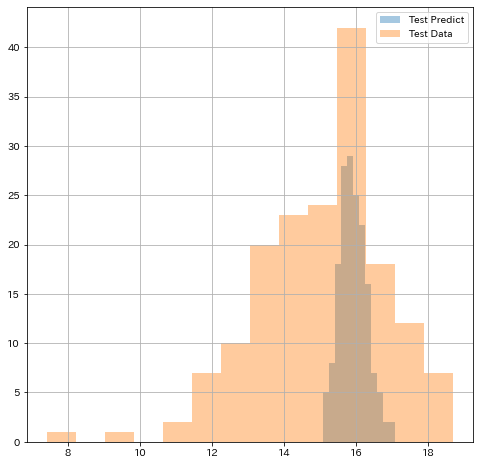

In [33]:
test_y=np.log1p(test['Total Gross'].values)

fig, ax = plt.subplots(figsize=(8, 8))

#変数を対数スケールで学習させなかった場合
sns.distplot(pred, label='Test Predict',kde=False)
sns.distplot(test_y, label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')


#変数を対数スケールで学習させた場合
#sns.distplot(np.log1p(pred), label='Test Predict',kde=False)
#sns.distplot(np.log1p(test_y), label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


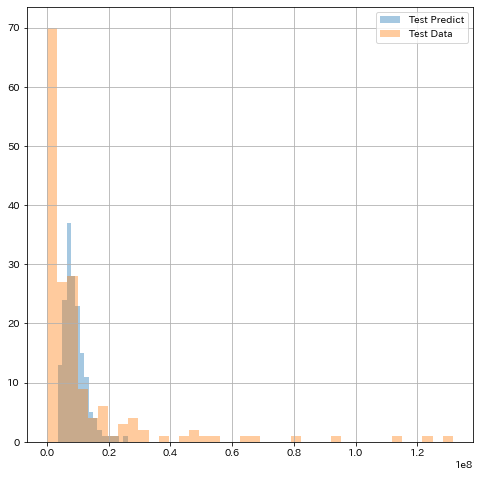

In [34]:
test_y=test['Total Gross'].values

fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.expm1(pred), label='Test Predict', kde=False)
sns.distplot(test_y, label='Test Data', kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

In [35]:
import matplotlib.pyplot as plt 
%matplotlib inline 
def yyplot(y_obs, y_pred):
  yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
  ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
  fig = plt.figure(figsize=(6,6))
  plt.scatter(y_obs, y_pred)
  plt.plot([ymin - yrange*0.01, ymax + yrange*0.01],[ymin - yrange * 0.01, ymax + yrange * 0.01])
  plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.xlabel('y_obserbed', fontsize=24)
  plt.ylabel('y_predicted', fontsize=24)
  plt.title('yyplot', fontsize=24)
  plt.tick_params(labelsize=16)
  plt.show() 

  return fig

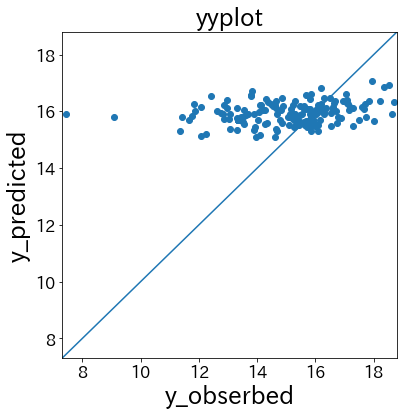

In [36]:
test_y=test['Total Gross'].values

fig = yyplot(np.log1p(test_y), pred)

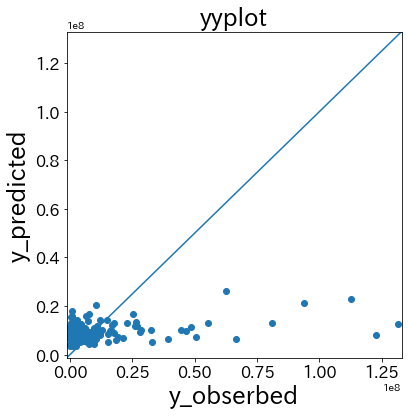

In [37]:
fig = yyplot(test_y, np.expm1(pred))

In [38]:
#決定係数
#r2_score(y_true, y_pred)
print(r2_score(test_y, np.expm1(pred)))

0.08626409798464907


In [39]:
t_y=np.log1p(test_y)
p_y=pred
#print(len(t_y),len(p_y))
print(r2_score(t_y, p_y))

-0.16704213325394623


In [40]:
def show_evals_result(evals_result:dict):

    #rmse
    eval_metric_rmse = evals_result['valid']['rmse']
    train_metric_rmse = evals_result['train']['rmse']

    """
    # 組み込みのメトリック
    eval_metric_logloss = evals_result['valid']['binary_logloss']
    train_metric_logloss = evals_result['train']['binary_logloss']

    # カスタムメトリック (Accuracy)
    eval_metric_acc = evals_result['valid']['accuracy']
    train_metric_acc = evals_result['train']['accuracy']

    # カスタムメトリック (Precision)
    eval_metric_prec = evals_result['valid']['precision']
    train_metric_prec = evals_result['train']['precision']

    # カスタムメトリック (recall)
    eval_metric_recall = evals_result['valid']['recall']
    train_metric_recall = evals_result['train']['recall']

    # カスタムメトリック (F1_macro)
    eval_metric_f1macro = evals_result['valid']['f1_macro']
    train_metric_f1macro = evals_result['train']['f1_macro']
    """


    # グラフにプロットする
    _, ax1 = plt.subplots(figsize=(16, 16))
    ax1.plot(eval_metric_rmse, label='valid logloss', c='y')
    ax1.plot(train_metric_rmse, label='train logloss', c='b')
    ax1.set_ylabel('root mean square error')
    ax1.set_xlabel('rounds')
    ax1.legend()

    #ax2 = ax1.twinx()
    #ax2.plot(eval_metric_rmse, label='valid rmse')
    #ax2.plot(train_metric_rmse, label='train rmse')

    #ax2.plot(eval_metric_acc, label='valid accuracy')
    #ax2.plot(train_metric_acc, label='train accuracy')
    #ax2.plot(eval_metric_prec, label='valid precision')
    #ax2.plot(train_metric_prec, label='train precision')
    #ax2.plot(eval_metric_recall, label='valid recall')
    #ax2.plot(train_metric_recall, label='train recall')
    #ax2.plot(eval_metric_f1macro, label='valid f1_macro')
    #ax2.plot(train_metric_f1macro, label='train f1_macro')
    #ax2.set_ylabel('ratio')
    #ax2.legend()

    plt.grid()
    plt.show()

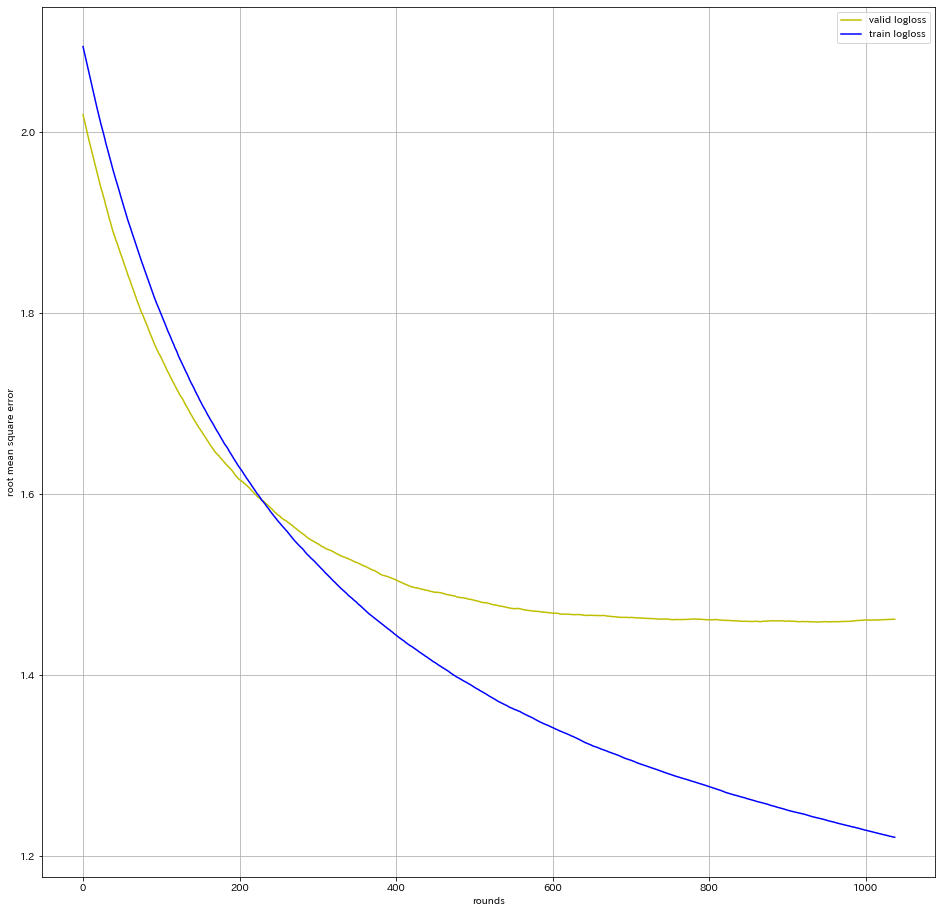

In [41]:
show_evals_result(evals_result)

In [42]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance('gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

   
    #feature_importance_df = feature_importance_df[feature_importance_df['feature_importance']>0]
    #sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance',  ax=ax, palette='ocean')
    #fig, ax = plt.subplots(figsize=(15, 20))

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(20, 20))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

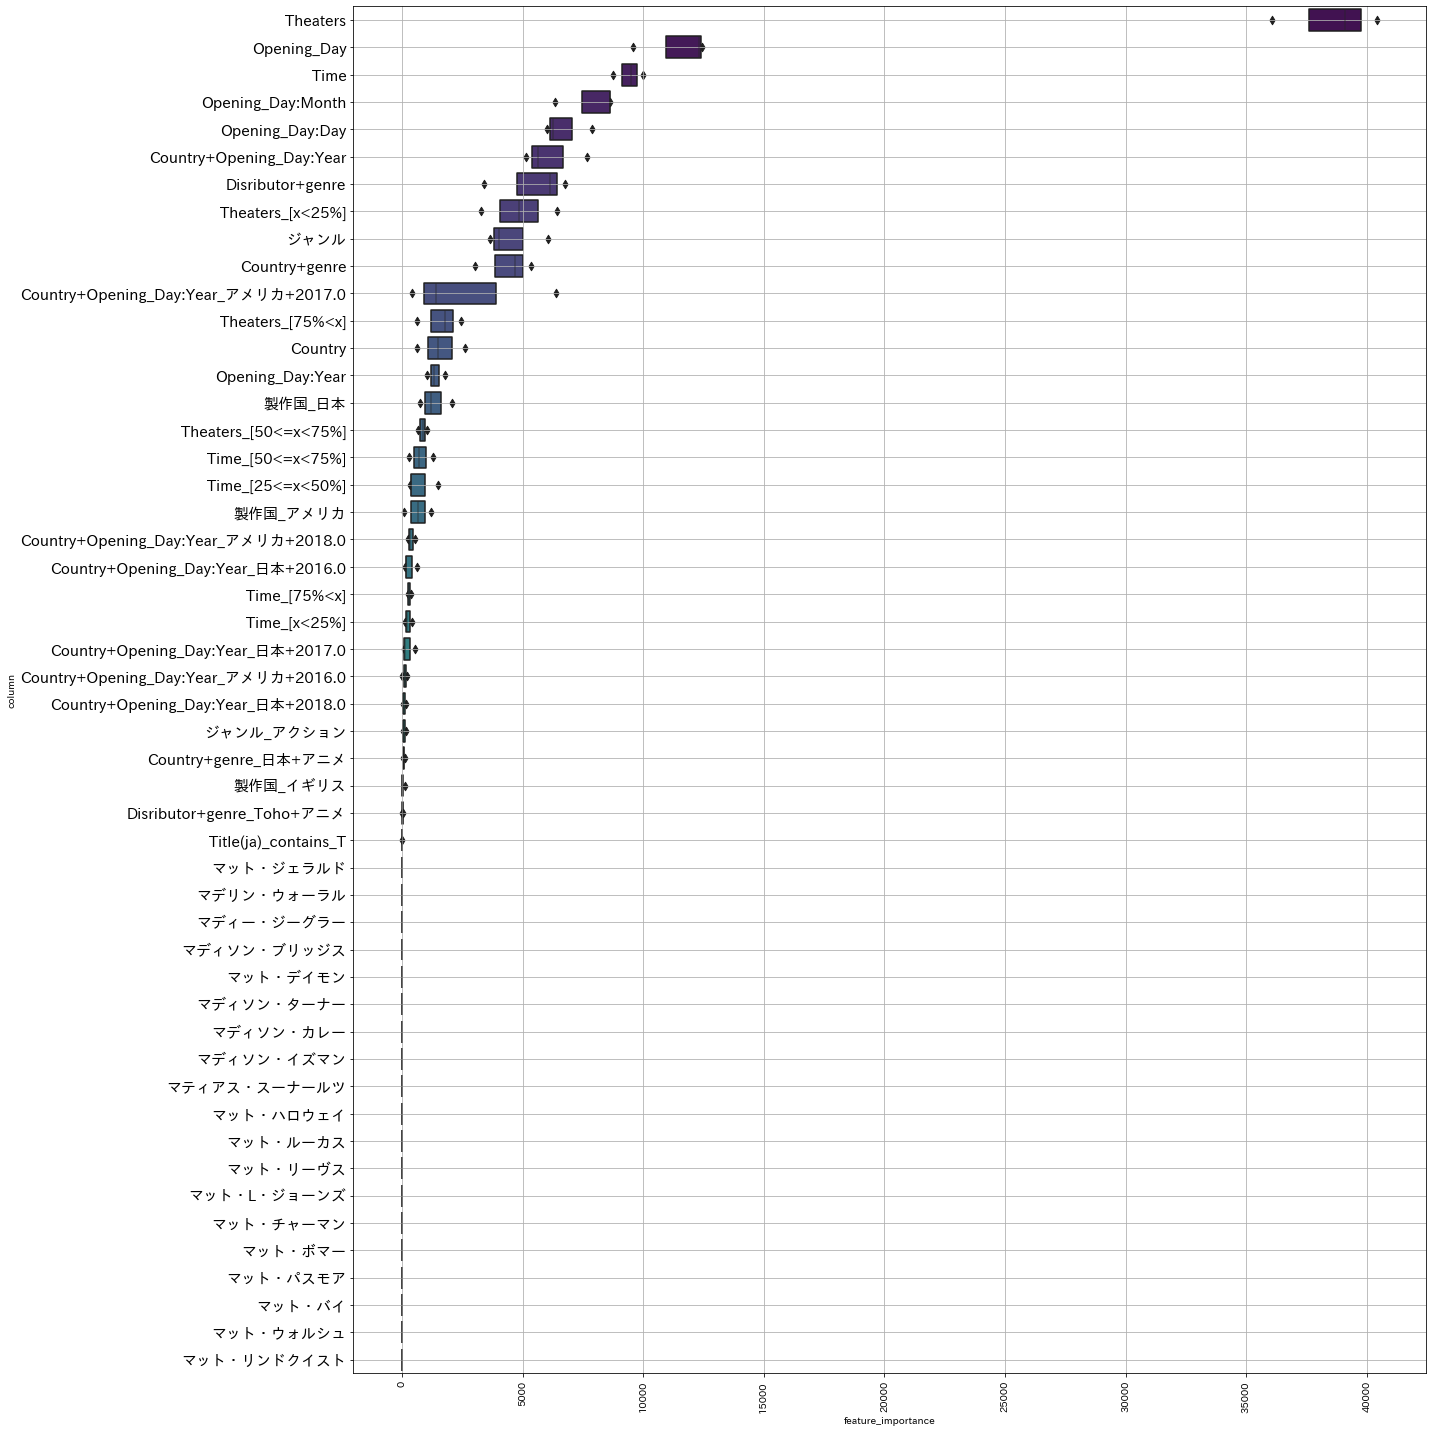

In [43]:
fig, ax, feature_importance_df = visualize_importance(models, train_features.drop([target_col, 'kfold'], axis=1))

In [44]:
"""# 決定木を可視化
def display_tree(clf):
    ax = lgb.plot_tree(clf, tree_index=0, figsize=(30, 30), show_info=['split_gain'])
    plt.show()
    print('lightGBM　木の可視化')
    graph = lgb.create_tree_digraph(clf, tree_index=0, format='png', name='Tree')
    graph.render(view=True)

for i in models:
  display_tree(i)
  
"""


"# 決定木を可視化\ndef display_tree(clf):\n    ax = lgb.plot_tree(clf, tree_index=0, figsize=(30, 30), show_info=['split_gain'])\n    plt.show()\n    print('lightGBM\u3000木の可視化')\n    graph = lgb.create_tree_digraph(clf, tree_index=0, format='png', name='Tree')\n    graph.render(view=True)\n\nfor i in models:\n  display_tree(i)\n  \n"

In [45]:
feature_importance_df.groupby('column').sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False)[0:50]

,feature_importance
column,
Theaters,115599.289121
Opening_Day,34355.993740
Time,28210.462652
Opening_Day:Month,23561.741428
Opening_Day:Day,20139.914427
Country+Opening_Day:Year,18455.992561
Disributor+genre,16279.168353
Theaters_[x<25%],14542.021106
ジャンル,13705.309608


#ジャンルが重要視されていることが分かった．ジャンルに関する特徴量を作ると良いかもしれない．<br>
ジャンルに関するaggregrationなど

#aditional data 

https://gem-standard.com/news_releases/244